### Buisness context

Central banks collect information/feedback/complaints from customers on different services provided by different banks.
    1. Bank users give ratings and reviews to the services on bank website. These ratings are useful to the banks in evaluating their services and take necessary action to improve their services. Ratings help the bansk understand the overall experience but they do not convey the context ehich led the reviewer to that experience.
    
    2. If we look at the rating alone, it is difficult to guaze why the review gave a 4 or a 2 start rating. But, if we read the review it is not difficult to understand that the reviewer talks about good service/bad service/expectations.
    

### Objective:
    The objective of this case study is to analyse customer reviews and predict customer satisfaction with the reviews.
    1. Data Processing
    2. Key positive words, negative words (most frequent words)
    3. Classification of reviews into positive, negative and neutral
    4. Identify key themes of problems (using clustering/topic models)
    5. Predicting start ratings using reviews
    6. Perform intent analysis

In [883]:

import pandas as pd 
import numpy as np

import pandas_profiling

from textblob import TextBlob
from textblob import Word

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import string
import re

from nameparser.parser import HumanName

import spacy

import nltk
import nltk.chunk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score

from xgboost import XGBClassifier

# Importing Gensim
import gensim
from gensim import corpora
import pyLDAvis.gensim

#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mayukh S. Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Mayukh
[nltk_data]     S. Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Mayukh S.
[nltk_data]     Mishra\AppData\R

<Figure size 432x216 with 0 Axes>

In [889]:
# read BankReviews.xlsx into a DataFrame
bank_reviews = pd.read_excel('BankReviews.xlsx')

### Data Understanding

In [890]:
bank_reviews.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [891]:
bank_reviews.head(5)

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [892]:
bank_reviews.shape

(505, 4)

In [893]:
bank_reviews.describe()

,Stars
count,505.000000
mean,4.247525
std,1.564778
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [894]:
#full report with correlation and missing charts was generating a report of size more than 250 MBs, 
#this was causing my machine to hang. Hence, generating a minimal report with varibale info and overview.

profile = pandas_profiling.ProfileReport(bank_reviews, minimal=True)

In [895]:
# Change the config after
#profile.set_variable("html.minify_html", False)
profile.to_file("profile_report.html")

### Exploratory analysis

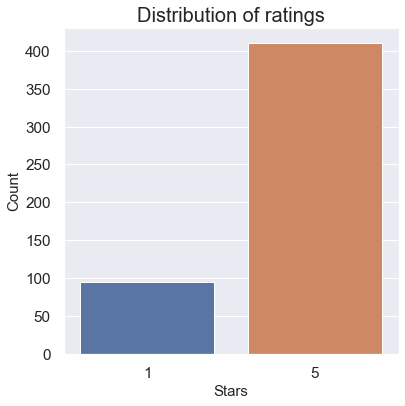

In [896]:
stars = bank_reviews.groupby(bank_reviews['Stars']).size()

fig, axs = plt.subplots(figsize = (6,6))
sns.barplot(stars.index, stars.values,  orient='v')

plt.title('Distribution of ratings',fontsize=20)
plt.xlabel('Stars',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

#### The data has ratings of only 1 start and 5 star

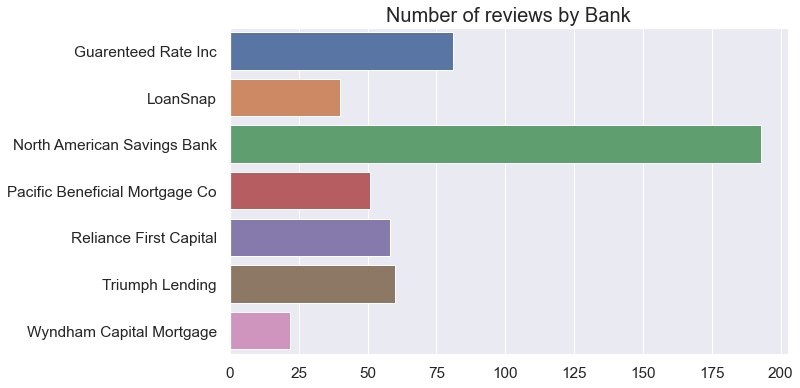

In [897]:
bank = bank_reviews.groupby(bank_reviews['BankName']).size()

fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(bank.values, bank.index)

plt.title('Number of reviews by Bank',fontsize=20)
#plt.xlabel('Count',fontsize=15)
plt.ylabel('',fontsize=15)
plt.show()

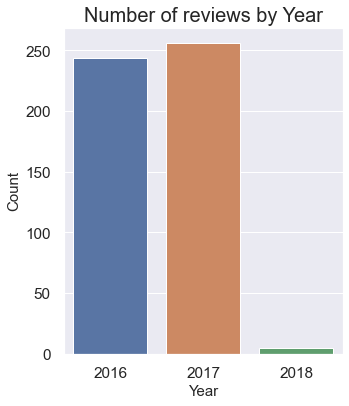

In [898]:
year = bank_reviews.groupby(bank_reviews['Date'].dt.year).size()

fig, axs = plt.subplots(figsize = (5,6))
sns.barplot(year.index, year.values,  orient='v')

plt.title('Number of reviews by Year',fontsize=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

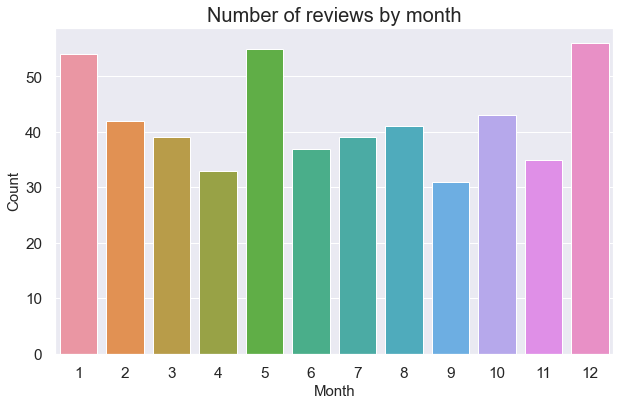

In [899]:
month = bank_reviews.groupby(bank_reviews['Date'].dt.month).size()

fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(month.index, month.values,  orient='v')

plt.title('Number of reviews by month',fontsize=20)
plt.xlabel('Month',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [900]:
review_data = bank_reviews.copy()

### Data preparation and processing

In [901]:
## drop duplicate rows:
review_data.drop_duplicates(keep='first',inplace=True) 

In [902]:
## check for missing values
count_missing = review_data.isnull().sum()
percent_missing = count_missing * 100 / len(review_data)
missing_value_df = pd.DataFrame({'count_missing': count_missing, 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
missing_value_df.head(10)

,count_missing,percent_missing
Date,0,0.0
Stars,0,0.0
Reviews,0,0.0
BankName,0,0.0


In [903]:
#keepin a copy of the original reviews
review_data['Reviews_Orig'] = review_data['Reviews'] 

In [904]:
#Word count in each comment:
review_data['count_word']=review_data["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
review_data['count_unique_word']=review_data["Reviews"].apply(lambda x: len(set(str(x).split())))

review_data.head(5)

,Date,Stars,Reviews,BankName,Reviews_Orig,count_word,count_unique_word
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,"Great job, Wyndham Capital! Each person was pr...",19,19
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,Matthew Richardson is professional and helpful...,25,23
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,We had a past experience with Wyndham Mortgage...,79,64
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,We have been dealing with Brad Thomka from the...,108,78
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,I can't express how grateful I am for the supp...,59,47


In [905]:
print("Total word count in the corpus: ", review_data['count_word'].sum())
print("Total unique word count in the corpus: ", review_data['count_unique_word'].sum())

Total word count in the corpus:  38577
Total unique word count in the corpus:  28451


#### Getting all human names

In [906]:
nlp = spacy.load('en')
ents_list = []
for index, row in review_data.iterrows():
    doc = nlp(row['Reviews'])
    # Iterate over the predicted entities
    for ent in doc.ents:
        tmp = []
        if ent.label_ == 'PERSON':
            tmp.append(ent.text)
    ents_list.append(tmp)
    
flat_list = []
for sublist in ents_list:
    for item in sublist:
        flat_list.append(item.lower())
person_name_set = set(flat_list)
print(person_name_set)

{'kelly', 'sakani hamilton', 'jacob m. koppel', 'mary', 'andrew', 'jeff', 'adam', 'sam', 'june lee', 'andrew leehy', 'dyllon b.', 'gregory', 'mike', 'alex', 'lending tree', 'john guerra', 'carla', 'peter', 'ben', 'fred', 'spring', 'patrick', 'brandon', 'brad', 'joe', 'adan', 'janeen cadwell', 'nasb', 'jim', 'wesley white', 'anthony marroquin', 'robert mcclung', 'mattison', 'rich', 'mark', 'tom', 'jon', 'matthew', 'maurice', 'mark taylor', 'jeremy', 'patrick g', 'jon barrett', 'ranee martinez', 'joey', 'ed', 'malcolm', 'steve', 'robert', 'paul', 'bryan', 'bill', 'michele', 'bryant', 'anthony', 'kory', 'rowel', 'jason', 'dlj', 'andy', 'jody martin', 'christopher waymire', 'aaron', 'triumph', 'janeen', 'john', 'michelle', 'ethan', 'lindread less', 'adaml', 'matt', 'dean', "austen butler's", 'chris', 'joanne', 'tim', 'brent', 'daniel', 'rick richter', 'teddy', 'germain', 'thanks patrick', 'steven shatz', 'brian', 'penny', 'peter lammerts', 'rick', 'steven', 'wyndham', 'kirk', 'chris thomas

In [907]:
def clean_text(text):
    
    # remove web addresses
    text = re.sub('(www\.[^\s]+)|(https?://[^\s]+)','', text)

    # Remove Emails
    text = re.sub('\S*@\S*\s?', '', text)

    #remove numbers (this would take care of telephones too)
    text = re.sub(r'\d+', '', text)

    # Remove new line characters
    text = re.sub('\s+', ' ', text)

    #remove special characters
    text = re.sub("[-()\"#/@;&:{}`+=~|.!?,'0-9]", "", text)

    #remove continuos spaces with one space character
    text = re.sub(' +', ' ', text)
    
    # to lower case
    text = text.lower()
    
    return(text)

#it seems that stop word match should be in lower case
def to_lower(text):
    #all words to lower case
    return text.lower()

#def count_words_corpus(docs):
#    #Word count in each comment:
#    df['count_word'] = df["text"].apply(lambda x: len(str(x).split()))

<>:4: DeprecationWarning: invalid escape sequence \.
<>:7: DeprecationWarning: invalid escape sequence \S
<>:13: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \.
<>:7: DeprecationWarning: invalid escape sequence \S
<>:13: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \.
<>:7: DeprecationWarning: invalid escape sequence \S
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-907-81326dc14022>:4: DeprecationWarning: invalid escape sequence \.
  text = re.sub('(www\.[^\s]+)|(https?://[^\s]+)','', text)
<ipython-input-907-81326dc14022>:7: DeprecationWarning: invalid escape sequence \S
  text = re.sub('\S*@\S*\s?', '', text)
<ipython-input-907-81326dc14022>:13: DeprecationWarning: invalid escape sequence \s
  text = re.sub('\s+', ' ', text)


In [908]:
#removing stop words
def pre_process(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words)) #Removing stop words
    return(text)

It seems that stop word match should be in lower case. Hence, changing everything to lower, then remove punctutions and finally clean the text.

In [909]:
review_data['Reviews'] = review_data["Reviews"].apply(lambda x: to_lower(x))

In [910]:
#clear stop words
review_data['Reviews'] = pre_process(review_data["Reviews"])

In [911]:
#remove special characters
review_data['Reviews'] = review_data["Reviews"].apply(lambda x: clean_text(x))

In [912]:
review_data.head(5)

,Date,Stars,Reviews,BankName,Reviews_Orig,count_word,count_unique_word
0,2017-04-10,5,great job wyndham capital person professional ...,Wyndham Capital Mortgage,"Great job, Wyndham Capital! Each person was pr...",19,19
1,2017-02-10,5,matthew richardson professional helpful helped...,Wyndham Capital Mortgage,Matthew Richardson is professional and helpful...,25,23
2,2017-08-21,5,past experience wyndham mortgage would without...,Wyndham Capital Mortgage,We had a past experience with Wyndham Mortgage...,79,64
3,2017-12-17,5,dealing brad thomka beginning started stressfu...,Wyndham Capital Mortgage,We have been dealing with Brad Thomka from the...,108,78
4,2016-05-27,5,cant express grateful support zach provided fa...,Wyndham Capital Mortgage,I can't express how grateful I am for the supp...,59,47


### Lemmitization

In [913]:
#Map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "UH": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [914]:
wordnet_lemmatizer = WordNetLemmatizer()

In [915]:
for index, row in review_data.iterrows():
    sentence_words = nltk.word_tokenize(row['Reviews'])
    tmp = []
    for word in sentence_words:
        if len(word) > 3 and word not in person_name_set:
            t = wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word))
            if len(t) > 2:
                tmp.append(t)
    text = " ".join(tmp)
    review_data.loc[index, 'Reviews'] = text

review_data.head(5)

,Date,Stars,Reviews,BankName,Reviews_Orig,count_word,count_unique_word
0,2017-04-10,5,great capital person professional help move re...,Wyndham Capital Mortgage,"Great job, Wyndham Capital! Each person was pr...",19,19
1,2017-02-10,5,richardson professional helpful help find corr...,Wyndham Capital Mortgage,Matthew Richardson is professional and helpful...,25,23
2,2017-08-21,5,past experience mortgage would without questio...,Wyndham Capital Mortgage,We had a past experience with Wyndham Mortgage...,79,64
3,2017-12-17,5,deal thomka begin start stressful time help en...,Wyndham Capital Mortgage,We have been dealing with Brad Thomka from the...,108,78
4,2016-05-27,5,cant express grateful support zach provide fam...,Wyndham Capital Mortgage,I can't express how grateful I am for the supp...,59,47


### Calculating if the review is Negative, Positive or Neutral 

In [916]:
## This function accepts text/review and returns if the review was Positive, Negative or Neutral
def sentiment_review(text):
    review = TextBlob(text)    
    polarity_score = review.sentiment.polarity
    if polarity_score > 0:
        return 'Positive'
    elif polarity_score < 0:
        return 'Negative'
    else:
        return 'Neutral' 

senti_df = pd.DataFrame()
senti_df = review_data[["Reviews_Orig","Stars"]].copy()
#only applying the text cleaning
senti_df['Reviews'] = senti_df["Reviews_Orig"].apply(lambda x: clean_text(x))
senti_df['sentiment'] = senti_df['Reviews'].apply(lambda x: sentiment_review(x))

In [917]:
senti_df.head(5)

,Reviews_Orig,Stars,Reviews,sentiment
0,"Great job, Wyndham Capital! Each person was pr...",5,great job wyndham capital each person was prof...,Positive
1,Matthew Richardson is professional and helpful...,5,matthew richardson is professional and helpful...,Positive
2,We had a past experience with Wyndham Mortgage...,5,we had a past experience with wyndham mortgage...,Negative
3,We have been dealing with Brad Thomka from the...,5,we have been dealing with brad thomka from the...,Positive
4,I can't express how grateful I am for the supp...,5,i cant express how grateful i am for the suppo...,Positive


In [918]:
#there have been misclassifications, below is and example with 1 star rating but positive sentiment
senti_df.loc[504]['Reviews_Orig']

"\r\nI was working with a loan consultant from NASB and she told me that she would give me a rate of 4.875% for a 30 year fixed loan with a total closing cost of $2300. I asked her to send me the good faith estimate. The good faith estimate came with a total closing cost of $2929 which is about $600 more than she mentioned during our conversation. When I called her for explanation of the extra $600 she said that there is a state tax 545.10 which she was not aware of. What an explanation!!!! She knew my state from the beginning and I repeatedly asked her for a 'TOTAL' closing cost and that time she repeatedly said it will be $2300. As a loan consultant she should have known that there is something like a 'STATE TAX' that might come later and should have mentioned that to me. I am not supposed to know what are the different compoents/fees or taxes that apply during closing. She does this everyday and she could have been honest with me from the beginning. I expected honest communication f

In [919]:
pd.crosstab(senti_df.sentiment, senti_df.Stars)

Stars,1,5
sentiment,,
Negative,28,6
Neutral,4,0
Positive,62,403


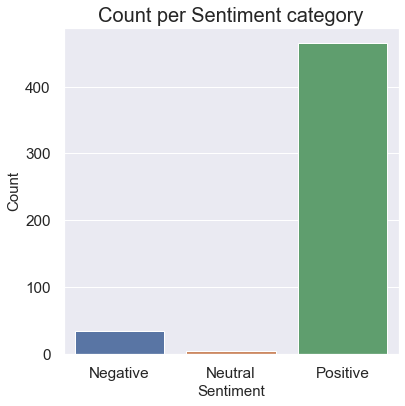

In [920]:
sentiment = senti_df.groupby(senti_df['sentiment']).size()

fig, axs = plt.subplots(figsize = (6,6))
sns.barplot(sentiment.index, sentiment.values,  orient='v')

plt.title('Count per Sentiment category',fontsize=20)
plt.xlabel('Sentiment',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

Maximum number of reviews were classified as Positive, this was expected as over 400 out of 500 reviews were, 5 start reviews.
Since, all reviews in the data were either 1 start or 5 star, it was expected that neutral reviews would be close to zero.
There were certain mis-matches between the sentiment and star ratings, as can be observed from the cross-tab


### Key positive words, negative words (most frequent words) 

#### Get DTM for all reviews

In [921]:
#Vectorization
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             lowercase = True,
                             encoding='latin-1' , 
                             max_features=1000)
reviews_count = count_vect.fit_transform(review_data['Reviews'])

In [922]:
#Get Document Term Matrix

#convert to word count 2D array
dtm_array = reviews_count.toarray()
#get all words as columns
dtm_cols = count_vect.get_feature_names()
#convert word count 2D array to dataframe
reviews_dtm = pd.DataFrame(dtm_array)
#add column names
reviews_dtm.columns = dtm_cols
reviews_dtm.head(5)

,ability,able,absolutely,accept,accommodate,account,accurate,achieve,across,actual,...,without,wonderful,word,work,worth,would,wouldn,write,wrong,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [923]:
## count words
word_freq = pd.DataFrame(reviews_dtm.apply(sum), columns=['freq'])
word_freq.reset_index(level=0, inplace=True)
word_freq.rename(columns={'index': 'Term'}, inplace=True)

In [924]:
## This function accepts text and returns if the text was Positive, Negative
def neg_pos_txt(text):
    review = TextBlob(text)    
    polarity_score = review.sentiment.polarity
    if polarity_score > 0:
        return 'Positive'
    else:
        return 'Negative' 

In [925]:
#categories words as negative, positive, neutral with TextBlob sentiment.polarity
word_freq['sentiment'] = word_freq["Term"].apply(lambda x: neg_pos_txt(x))
word_freq.head(10)

,Term,freq,sentiment
0,ability,5,Negative
1,able,47,Positive
2,absolutely,13,Positive
3,accept,6,Negative
4,accommodate,7,Negative
5,account,15,Negative
6,accurate,10,Positive
7,achieve,5,Negative
8,across,13,Negative
9,actual,8,Negative


In [926]:
word_freq.groupby('sentiment').size()

sentiment
Negative    541
Positive     82
dtype: int64

In [927]:
# separating positive words
positive_words = word_freq.loc[word_freq['sentiment']=='Positive',:].sort_values('freq',ascending=False)

#ten most frequently used positive words.
positive_words = positive_words.head(20)
positive_words

,Term,freq,sentiment
231,great,138,Positive
64,best,99,Positive
209,first,78,Positive
156,easy,76,Positive
417,professional,71,Positive
248,highly,64,Positive
541,thanks,61,Positive
529,sure,51,Positive
1,able,47,Positive
228,good,43,Positive


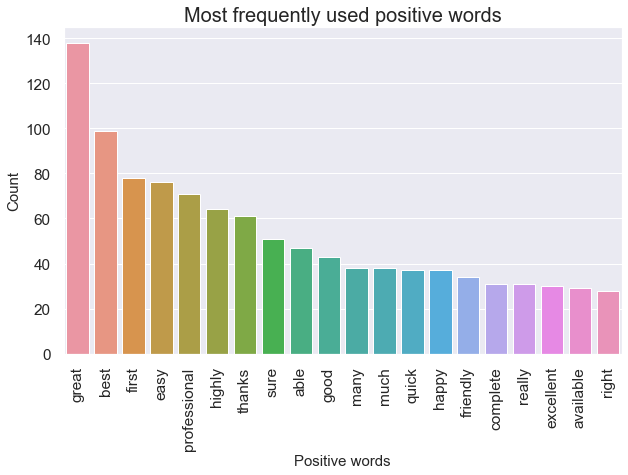

In [928]:
#plot most frequently used positive words
fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(positive_words['Term'], positive_words['freq'],  orient='v')

plt.title('Most frequently used positive words',fontsize=20)
plt.xlabel('Positive words',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(rotation=90)
plt.show()

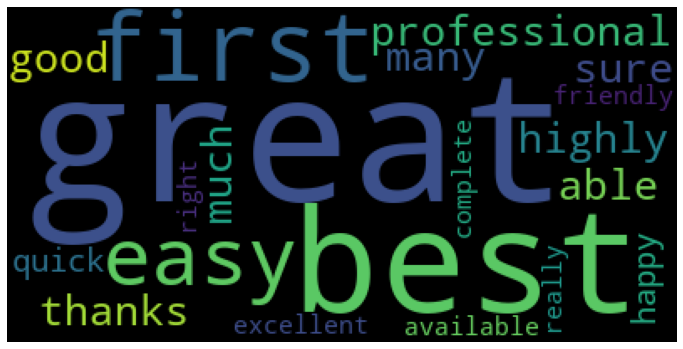

In [929]:
#word cloud of 10 most frequently used positive words
wordcloud = WordCloud().generate(' '.join(positive_words['Term']))
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")  
plt.show()

In [930]:
# separating negative words
negative_words = word_freq.loc[word_freq['sentiment']=='Negative',:].sort_values('freq',ascending=False)

#ten most frequently used positive words.
negative_words = negative_words.head(20)
negative_words

,Term,freq,sentiment
309,loan,327,Negative
616,work,291,Negative
413,process,256,Negative
618,would,246,Negative
556,time,221,Negative
317,make,202,Negative
250,home,197,Negative
437,read,190,Negative
444,recommend,175,Negative
336,mortgage,155,Negative


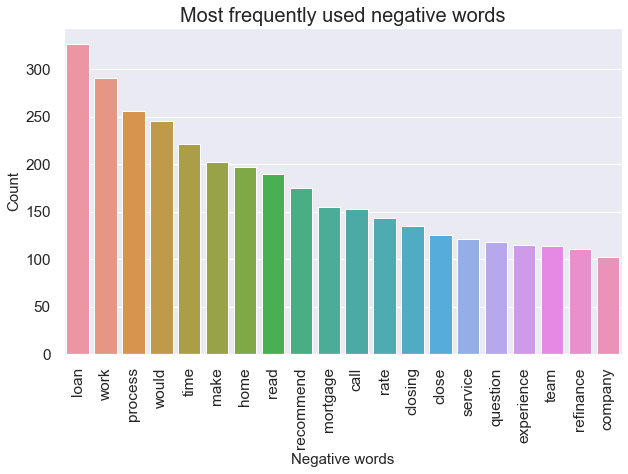

In [931]:
#plot most frequently used negative words
fig, axs = plt.subplots(figsize = (10,6))
sns.barplot(negative_words['Term'], negative_words['freq'],  orient='v')

plt.title('Most frequently used negative words',fontsize=20)
plt.xlabel('Negative words',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(rotation=90)
plt.show()

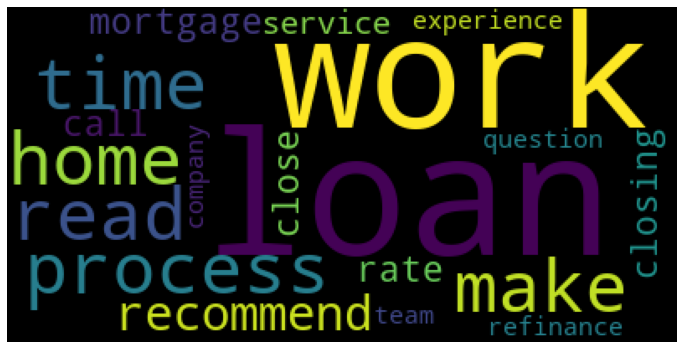

In [932]:
#word cloud of 10 most frequently used negative words
wordcloud = WordCloud().generate(' '.join(negative_words['Term']))
# plot the WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")  
plt.show()

### Split the data into train & Test

In [933]:
# split the new DataFrame into training and testing sets
y = review_data['Stars']
X = review_data['Reviews']
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(377,)
(126,)
(377,)
(126,)


### Vectorization (count, tfidf) for both train & test

In [934]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             lowercase = True,
                             encoding='latin-1' , 
                             max_features=1000)
train_X_count = count_vect.fit_transform(train_X)

tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)
train_X_tfidf = tfidf_vect.fit_transform(train_X)

#Test
test_X_count = count_vect.transform(test_X)
test_X_tfidf = tfidf_vect.transform(test_X)

In [935]:
#Get TF-IDF matrix

#convert to word count 2D array
tfidf_array = train_X_tfidf.toarray()
#get all words as columns
tfidf_cols = tfidf_vect.get_feature_names()
#convert word count 2D array to dataframe
train_tfidf = pd.DataFrame(tfidf_array)
#add column names
train_tfidf.columns = tfidf_cols
train_tfidf.head(5)

,able,absolutely,accept,accommodate,account,accurate,across,actual,additional,address,...,with,within,without,wonderful,word,work,would,write,wrong,year
0,0.0,0.0,0.141604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.109101,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.097593
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.222655,0.0,0.091574,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.355828,0.138106,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.149096,0.086802,0.0,0.0,0.000000


In [936]:
#Get Document Term Matrix
#convert to word count 2D array
dtm_array = train_X_count.toarray()
#get all words as columns
dtm_cols = count_vect.get_feature_names()
#convert word count 2D array to dataframe
train_dtm = pd.DataFrame(dtm_array)
#add column names
train_dtm.columns = dtm_cols
train_dtm.head(5)

,able,absolutely,accept,accommodate,account,accurate,across,actual,additional,address,...,with,within,without,wonderful,word,work,would,write,wrong,year
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0


In [937]:
## How many words ?
train_dtm.shape

(377, 508)

### Topic Modeling using sklearn.decomposition

In [938]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=50)
train_X_topics = lda_model.fit_transform(train_X_tfidf)
topic_word = lda_model.components_ 
terms = count_vect.get_feature_names()

In [939]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(terms)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['work process loan great would make home recommend time service',
 'informative responsive team home regulation close june truly believe rule',
 'would turn company help friend financing recommend fast leave easy',
 'loan people get helpful still service issue close able officer',
 'patient get well company give never work great friendly option',
 'loan email team good rate officer step mistake closing require',
 'orient professional customer delay situation wife company amaze multiple while',
 'great process compare difference lender want would necessary home value',
 'unprofessional outstanding previous number list timely contact phone lender always',
 'person email beneficial read send almost miss name really jocovic',
 'payment account letter show amount nasbs agent unlike instruct voice',
 'person commission heart name honest interest work hard customer best',
 'possible still pretty processing make really include hesitate throughout find',
 'sense closing horrible income local f

### Topic Modeling using gensim

In [940]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [941]:
train_X_tokens = [doc.split() for doc in train_X] 

In [942]:
dictionary = corpora.Dictionary(train_X_tokens)
print(dictionary)

Dictionary(1799 unique tokens: ['accept', 'agree', 'already', 'also', 'ask']...)


In [943]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_X_tokens]

In [944]:
#pyLDAvis usage
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [945]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary,passes=5, alpha='auto', eval_every=5)

In [946]:
pyLDAvis.enable_notebook()
#d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
#lda = gensim.models.LdaModel.load('topic.model')

In [948]:
data = pyLDAvis.gensim.prepare(ldamodel, c, dictionary)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.050366  0.060882       1        1  43.864525
2     -0.017522 -0.092655       2        1  19.395967
0      0.062353 -0.016926       3        1  16.519121
3     -0.119863  0.033459       4        1  10.276922
4      0.024666  0.015240       5        1   9.943466, topic_info=           Term        Freq       Total Category  logprob  loglift
175        call  106.000000  106.000000  Default  30.0000  30.0000
148       email   65.000000   65.000000  Default  29.0000  29.0000
105      lender   62.000000   62.000000  Default  28.0000  28.0000
93        would  159.000000  159.000000  Default  27.0000  27.0000
1267  appraisal   23.000000   23.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
76         team    6.133527   73.338715   Topic5  -5.3231  -0.1731
174        best    5.896576   61.041130   Topic5  -5.3625  -0.0289
187     receive    5.453613   37.608906   Topic5  -5.4406   0.3773
74      service    5.598236   86.238632   Topic5  -5.4144  -0.4264
22         home    5.558528  127.198341   Topic5  -5.4215  -0.8222

[388 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
471       1  0.383599        able
471       2  0.383599        able
471       3  0.174363        able
471       5  0.034873        able
814       1  0.122956  absolutely
...     ...       ...         ...
484       3  0.666067       wrong
52        1  0.684593        year
52        3  0.114099        year
52        4  0.028525        year
52        5  0.171148        year

[708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

In [949]:
print(ldamodel.print_topics(num_topics=5, num_words=10))

[(0, '0.012*"make" + 0.011*"recommend" + 0.011*"would" + 0.009*"process" + 0.009*"could" + 0.009*"read" + 0.009*"work" + 0.008*"question" + 0.008*"mortgage" + 0.008*"time"'), (1, '0.024*"loan" + 0.022*"work" + 0.019*"process" + 0.018*"home" + 0.016*"make" + 0.014*"time" + 0.014*"recommend" + 0.014*"would" + 0.012*"great" + 0.011*"read"'), (2, '0.019*"loan" + 0.012*"read" + 0.012*"rate" + 0.012*"process" + 0.011*"call" + 0.010*"lender" + 0.010*"closing" + 0.009*"time" + 0.008*"would" + 0.008*"week"'), (3, '0.019*"would" + 0.018*"call" + 0.015*"email" + 0.011*"work" + 0.011*"appraisal" + 0.011*"lender" + 0.011*"receive" + 0.010*"customer" + 0.009*"loan" + 0.008*"say"'), (4, '0.014*"close" + 0.014*"work" + 0.012*"time" + 0.012*"loan" + 0.011*"would" + 0.010*"process" + 0.010*"rate" + 0.009*"mortgage" + 0.009*"bank" + 0.008*"read"')]


In [950]:
topics = ldamodel.show_topics(formatted=False, num_topics=5, num_words=10)
    
for t in range(len(topics)):
    print("\nTopic {}, top {} words:".format(t+1,10))
    print(" ".join([w[0] for w in topics[t][1]]))


Topic 1, top 10 words:
make recommend would process could read work question mortgage time

Topic 2, top 10 words:
loan work process home make time recommend would great read

Topic 3, top 10 words:
loan read rate process call lender closing time would week

Topic 4, top 10 words:
would call email work appraisal lender receive customer loan say

Topic 5, top 10 words:
close work time loan would process rate mortgage bank read


In [953]:
#get topic related to each review
def dominant_topic(ldamodel, corpus, texts):
    #Function to find the dominant topic in each review
    topics_df = pd.DataFrame() 
    # Get main topic in each review
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # =&gt; dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)

In [954]:
df_dominant_topic = dominant_topic(ldamodel=ldamodel, corpus=doc_term_matrix, texts=review_data['Reviews']) 
df_dominant_topic.head()
df_dominant_topic.to_csv('topics.csv')

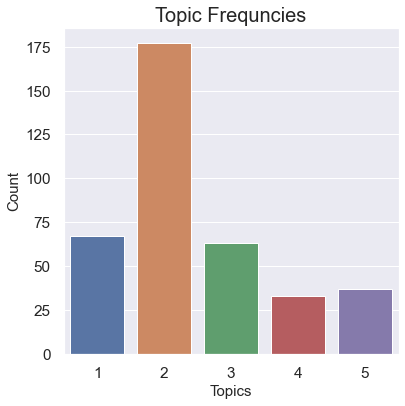

In [955]:
#plot topic frequency in the corpus
dom_topics = df_dominant_topic.groupby(df_dominant_topic['Dominant_Topic']).size()
index_int = dom_topics.index.astype(int) + 1
fig, axs = plt.subplots(figsize = (6,6))
sns.barplot(index_int, dom_topics.values,  orient='v')

plt.title('Topic Frequncies',fontsize=20)
plt.xlabel('Topics',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

### Segmentation (KMeans clustering)

In [956]:
km_4 = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1, random_state=123).fit(train_X_tfidf)
km_5 = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=1, random_state=123).fit(train_X_tfidf)
km_6 = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1, random_state=123).fit(train_X_tfidf)
km_7 = KMeans(n_clusters=7, init='k-means++', max_iter=100, n_init=1, random_state=123).fit(train_X_tfidf)
km_8 = KMeans(n_clusters=8, init='k-means++', max_iter=100, n_init=1, random_state=123).fit(train_X_tfidf)

In [957]:
terms = np.array(tfidf_vect.get_feature_names())
num_clusters = [4,5,6,7,8]
km_models = [km_4, km_5, km_6, km_7, km_8 ]

In [958]:
vocab_frame=pd.DataFrame({'words':terms},index=[terms])
N=10

print("Top terms for all cluster:")
print()

for j in num_clusters:
    #sort cluster centers by proximity to centroid
    order_centroids = km_models[j-4].cluster_centers_.argsort()[:, ::-1] 
    print()
    print('Top terms for CLUSTERS CENTERS = ', j)     
    for i in range(j):
        print("Cluster %d:" % i, end='')    
        for ind in order_centroids[i, :N]: #replace 10 with n words per cluster
            print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print()

Top terms for all cluster:


Top terms for CLUSTERS CENTERS =  4
Cluster 0: work, great, with, process, responsive, throughout, team, well, recommend, pleasure,
Cluster 1: make, home, experience, able, process, work, first, time, thanks, everything,
Cluster 2: loan, service, would, mortgage, recommend, company, helpful, process, home, great,
Cluster 3: rate, call, loan, closing, email, lender, would, time, told, take,

Top terms for CLUSTERS CENTERS =  5
Cluster 0: work, with, great, responsive, process, throughout, well, refinance, pleasure, june,
Cluster 1: able, informative, pleasure, helpful, work, lender, issue, close, make, still,
Cluster 2: company, loan, mortgage, helpful, service, would, business, customer, help, recommend,
Cluster 3: closing, loan, rate, call, lender, would, email, time, week, say,
Cluster 4: home, process, great, make, team, recommend, work, time, always, service,

Top terms for CLUSTERS CENTERS =  6
Cluster 0: work, with, great, process, responsive, through

In [959]:
#checking segment distribution
cluster_dist = []
for i,j in zip(km_models, num_clusters):
    for k in range(j):
        inner = []
        tmpstr = 'Cluster_' + str(j)
        inner.append(tmpstr)
        inner.append(k)
        inner.append(np.count_nonzero(i.labels_ == k))
        cluster_dist.append(inner)
    
cluster_dist_df = pd.DataFrame(cluster_dist, columns =['Cluster', 'Cluster_No', 'Count'])
cluster_dist_df[cluster_dist_df['Cluster'] == 'Cluster_5']

,Cluster,Cluster_No,Count
4,Cluster_5,0,54
5,Cluster_5,1,23
6,Cluster_5,2,60
7,Cluster_5,3,121
8,Cluster_5,4,119


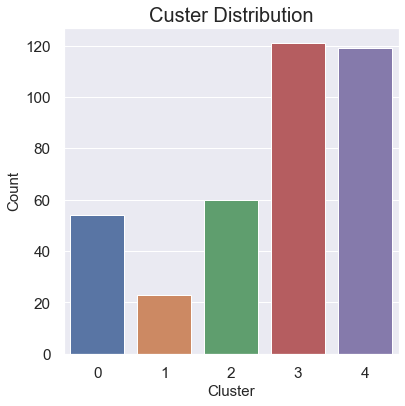

In [960]:
#plot topic frequency in the corpus
cluster5 = cluster_dist_df[cluster_dist_df['Cluster'] == 'Cluster_5']
fig, axs = plt.subplots(figsize = (6,6))
sns.barplot(cluster5['Cluster_No'], cluster5['Count'],  orient='v')

plt.title('Custer Distribution',fontsize=20)
plt.xlabel('Cluster',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [961]:
#compare SC scores for different cluster values
km_labels = [km_4, km_5, km_6, km_7, km_8]
sc_df = pd.DataFrame(columns = ['Cluster', 'SC_score'])

index = 0
for i in km_labels:
    sc_df.loc[index] = [i.n_clusters, silhouette_score(train_X_tfidf, i.labels_)]
    index = index + 1
    
sc_df = sc_df.sort_values(by='SC_score',ascending=False)
sc_df

,Cluster,SC_score
4,8.0,0.019093
2,6.0,0.017428
3,7.0,0.017347
1,5.0,0.016890
0,4.0,0.015220


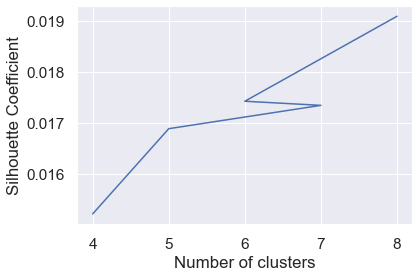

In [962]:
# plot SC scores
plt.plot(sc_df.Cluster, sc_df.SC_score)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [963]:
train_X_final = pd.concat([pd.DataFrame(train_X, index=train_X.index), pd.DataFrame(km_7.labels_, index=train_X.index)],axis=1)

In [964]:
train_X_final.columns = ['text', 'cluster']
train_X_final

,text,cluster
501,start credit check without knowledge consent a...,3
345,work home purchase provide interest rate closi...,4
82,phenomenal work locate refinance work family w...,0
47,horrible experience excellent credit plenty in...,3
320,great experience work munoz team financial beg...,4
...,...,...
257,extremely efficient pleased streamline process...,5
73,work agent quick simple little thing complete ...,2
398,great experience work experienced knowledgeabl...,4
237,good news processing waive rate lock day close...,3


In [965]:
train_X_final.cluster.value_counts()

3    88
4    85
6    70
0    44
2    42
5    31
1    17
Name: cluster, dtype: int64

### Classification
### Predicting star ratings using reviews

#### Naive Bayes on TF-IDF

In [966]:
# building naive bayes model on TF-IDF
nb_model = naive_bayes.MultinomialNB()
nb_model.fit(train_X_tfidf,train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [967]:
predict_train = nb_model.predict(train_X_tfidf)
predict_test = nb_model.predict(test_X_tfidf)

In [968]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.946949602122016
Accuracy on test:  0.8968253968253969


In [969]:
print(metrics.classification_report(train_y,predict_train))

              precision    recall  f1-score   support

           1       0.97      0.76      0.85        74
           5       0.94      0.99      0.97       303

    accuracy                           0.95       377
   macro avg       0.95      0.88      0.91       377
weighted avg       0.95      0.95      0.94       377



In [970]:
print(metrics.classification_report(test_y,predict_test))

              precision    recall  f1-score   support

           1       1.00      0.35      0.52        20
           5       0.89      1.00      0.94       106

    accuracy                           0.90       126
   macro avg       0.95      0.68      0.73       126
weighted avg       0.91      0.90      0.87       126



In [971]:
# predict probabilities on train and test
predict_prob_train = nb_model.predict_proba(train_X_tfidf)[:,1]
predict_prob_test = nb_model.predict_proba(test_X_tfidf)[:,1]

In [972]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9916376772812417
ROC_AUC score on test:  0.9660377358490566


### building naive bayes model on count verctor - DTM

In [973]:
# building naive bayes model on count verctor - DTM
nb_model = naive_bayes.MultinomialNB()
nb_model.fit(train_X_count,train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [974]:
predict_train = nb_model.predict(train_X_count)
predict_test = nb_model.predict(test_X_count)

In [975]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.9681697612732095
Accuracy on test:  0.9365079365079365


In [976]:
# predict probabilities on train and test
predict_prob_train = nb_model.predict_proba(train_X_count)[:,1]
predict_prob_test = nb_model.predict_proba(test_X_count)[:,1]

In [977]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.98994291321024
ROC_AUC score on test:  0.9702830188679246


Confusion Matix:
 [[ 14   6]
 [  2 104]]


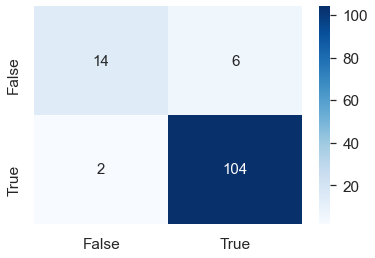

In [978]:
print('Confusion Matix:''\n', metrics.confusion_matrix(test_y, predict_test))
cf_matrix = metrics.confusion_matrix(test_y, predict_test)
categories = ['False', 'True']
plt.figure(figsize=(6,4))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={"size":15}, cmap='Blues', fmt='g', xticklabels=categories,  yticklabels=categories)
plt.show()

In [979]:
# Compute ROC curve and ROC area for each attack class
from itertools import cycle

def roc_curve_multinomial(train_y_multi, train_y_multi_pred):
    plt.figure(figsize=(8,6))
    n_classes = train_y_multi.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(train_y_multi[:, i], train_y_multi_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        colors = cycle(['blue', 'red', 'green','magenta','cyan'])
    for i, color in zip(range(n_classes), colors):
        if not np.isnan(tpr[i][0]):
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                 label='ROC curve of {0} Stars (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate(Recall)')
    plt.title('ROC curve for multinomial classification')
    plt.legend(loc="lower right")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


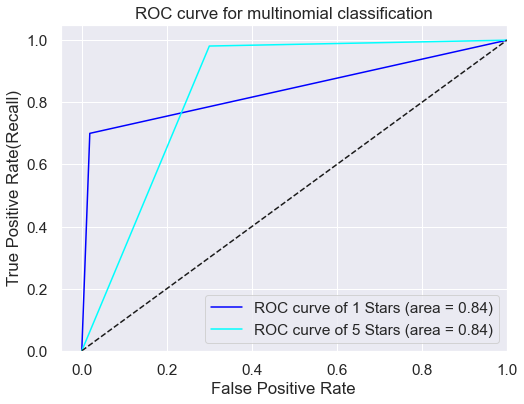

In [980]:
#Plot ROC AUC curve

#binarizing the predictions for ROC-AUC to work on multiclass predictions - star ratings 1 to 5
test_y_multi_pred = preprocessing.label_binarize(predict_test, classes=[1, 2, 3, 4, 5])
test_y_multi = preprocessing.label_binarize(test_y, classes=[1, 2, 3, 4, 5])

#auc_score = metrics.roc_auc_score(test_y,predict_prob_test)
#fpr, tpr, auc_thresholds = roc_curve(test_y,test_y_multi_pred)
roc_curve_multinomial(test_y_multi, test_y_multi_pred)

### XGBoost Classifier with Count Vector

In [981]:
xgb_estimator = XGBClassifier( learning_rate=0.01,
                               n_estimators=1000,
                               max_depth=5,
                               min_child_weight=1,
                               gamma=1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               n_jobs=-1,
                               reg_alpa=1,
                               scale_pos_weight=1,
                               random_state=42,
                               verbose=1)

In [982]:
xgb_estimator.fit(train_X_count,train_y)

[19:36:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { reg_alpa, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpa=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [983]:
predict_train = xgb_estimator.predict(train_X_count)
predict_test = xgb_estimator.predict(test_X_count)

In [984]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.9814323607427056
Accuracy on test:  0.9285714285714286


In [985]:
# predict probabilities on train and test
predict_prob_train = xgb_estimator.predict_proba(train_X_count)[:,1]
predict_prob_test = xgb_estimator.predict_proba(test_X_count)[:,1]

In [986]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9982160378199981
ROC_AUC score on test:  0.9764150943396226


### XGBoost Classifier with TFIDF

In [987]:
xgb_estimator.fit(train_X_tfidf,train_y)

[19:36:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { reg_alpa, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpa=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [988]:
predict_train = xgb_estimator.predict(train_X_tfidf)
predict_test = xgb_estimator.predict(test_X_tfidf)

In [989]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.986737400530504
Accuracy on test:  0.9047619047619048


In [990]:
# predict probabilities on train and test
predict_prob_train = xgb_estimator.predict_proba(train_X_tfidf)[:,1]
predict_prob_test = xgb_estimator.predict_proba(test_X_tfidf)[:,1]

In [991]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9989073231647488
ROC_AUC score on test:  0.9683962264150944


### We would choose Naive Bayes with CountVector DTM as our preffered model for Predicting star ratings using reviews.
It shows a little better accuracy on test data and it is faster.

In [992]:
### Saving as pickle object

#Lets save everything in metrics_df to pickle object
import pickle

# now you can save it to a file
with open('NB.pkl', 'wb') as f:
    pickle.dump(nb_model, f)